# Classifició d'Estats Cerebrals mitjançant Algorismes de Machine Learning


En aquest quart lliurament es programarà un classificador K-NN aplicat a la classifiació de dades neuronals.

**Introducció**

L'objectiu de l'experiment on es van recollir les dades és manipular l'estat motivacional del participant. Per saber si ho hem aconseguit, hem enregistrat les dades electro-encefalogràfiques (EEG) del nostre participant mentre feia l'experiment. Hem fet tres enregistraments, un per cadascuna de les tres manipulacions de motivació. I cadascun dels enregistraments s'ha fet amb un casc EEG de 60 electrodes (per tant un senyal 60-D), dura 1200ms, i es repeteix 108 vegades (l'experiment consisteix en 108 assajos).

# OBJECTIU DE LA PRACTICA

La vostra feina és consistirà en assistir en el desenvolupament del classificador. Gran part del codi vé donada, però haureu de completar algunes funcions.

Caldrà que us baixeu les dades d'aquest enllaç:

https://ubarcelona-my.sharepoint.com/:u:/g/personal/ignasi_cos_ub_edu/EUMkBulRicBLn3V9vadcGm4BQhgWs5DOO3aOmOus8qZ_6g?e=EKhy3C


Fareu servir les llibreries de python numpy, matplotlib, sklearn i scipy. 

## ANALISI DE LES DADES CEREBRALS


El notebook està dividit en 3 seccions, que s'executen seqüencialment:

1. A la primera part **visualitzarem** les dades electro-encefalogràfiques per cada estat motivacional.

2. A la segona part es fa un **pre-processament** de les dades, per distribuïr-lo en tres bandes de freqüència: baixes (alpha), mitges (beta) i altes (gamma).

3. A la tercera part **classicarem** els senyals corresponent a cada banda de freqüència.

### 1. Visualització de les Dades



El codi que es presenta a continuació carrega les dades (que cal es trobin al mateix directori del notebook) en una matriu 4-D, i defineix algunes variables globals.

** No modificar el codi següent **

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 25 17:34:37 2020

"""
import os
import numpy as np
import scipy.signal as spsg
import scipy.stats as stt
import scipy.io as sio
import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.preprocessing as skprp
import sklearn.pipeline as skppl
import sklearn.feature_selection as skfs
import sklearn.model_selection as skms
import sklearn.metrics as skm
import networkx as nx

import matplotlib.pyplot as pp

#%% general info

i_sub = 25

res_dir = '.'

n_motiv = 3

# load data
ts_tmp = sio.loadmat('dataClean2-'+str(i_sub)+'-T1.mat')['dataSorted2'] # [N,T,n_trials,motiv]   

N = 60 # number of channels
n_trials = 108 # number of trials per block
T = 1200 # trial duration

# discard silent channels
invalid_ch = np.logical_or(np.abs(ts_tmp[:,:,0,0]).max(axis=1)==0, np.isnan(ts_tmp[:,0,0,0]))
valid_ch = np.logical_not(invalid_ch)
ts_tmp = ts_tmp[valid_ch,:,:,:]
N = valid_ch.sum()

# get time series for each block
ts = np.zeros([n_motiv,n_trials,T,N])
for i_motiv in range(n_motiv):
    for i_trial in range(n_trials):
        # swap axes for time and channels
        ts[i_motiv,i_trial,:,:] = ts_tmp[:,:,i_trial,i_motiv].T
        
ts.shape

(3, 108, 1200, 48)

La matriu ts és 4-D, i conté els senyals d'interès per la pràctica. Les seves quatre dimensions fan referència a:

0. El nivell de motivació: 0, 1 o 2
1. El numero d'assaig (trial), entre 0 i 108
2. El temps, entre 0 i 1200ms
3. El numero de canal, entre 0 i 48.


**1. Visualitza les dades.**

Com que tenim quatre dimensions, el més apropiat per començar és calcular la mitja del senyal per cada estat motivacional (dimensió 0 de la matriu), i dibuixar un mapa de color amb la funció imshow de la llibreria matplotlib.

Es demana per tant, un colormap per cada estat motivacional. El procediment suggerit pot ser el següent:

1. Calcula la mitja de la matriu per tots els trials (dimensió 1). Això et reduirà la matriu a 3-D.

(48, 1200, 3)

2. Si selecciones el valor de la matriu resultant 3-D per cada estat motivacional, et resulten 3 matrius 2-D. Es tracta llavors de dibuixar tres colormaps (amb imshow), un per cada estat motivacional, amb eix x el temps (dimensió 2 de la matriu), com a eix y el numero de canal.

In [1]:
# Definicions genèriques
measure_labels = ['pow']
n_measures = len(measure_labels)

cmapcolours = ['Blues','Greens','Oranges']
listcolours = ['b','g','o']

freq_bands = ['alpha','beta','gamma']
n_bands = len(freq_bands)



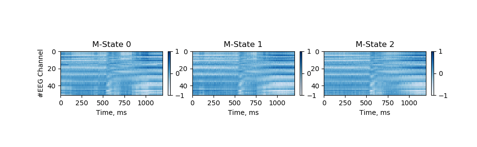

In [17]:
from IPython.display import Image
Image(filename='img/FIG11b.png')

### 2. Pre-processsament

Degut a la natura del senyal electro-encefalogràfic, cal descomposar el senyal en tres bandes de freqüència que el composen: freqüències baixes, mitges i altes. Dit d'altra manera, els senyals EEG es descomposen en la Banda Alpha (α: entre 8 -15 Hz), Banda Beta (β: entre 15-32 Hz) i Banda Gamma (γ: ≥ 32 Hz).

Com que es classifiquen de manera independent, haurem d'executar la nostra classificació tres vegades, una vegada per cada banda de freqüència.

In [34]:
ts2 = np.zeros([n_motiv,n_bands,T,N])
filtered_ts = np.zeros([n_bands,n_motiv,n_trials,T,N])
for i_band in range(n_bands):

    # select band
    freq_band = freq_bands[i_band]

    # band-pass filtering (alpha, beta, gamma)
    n_order = 3
    sampling_freq = 500. # sampling rate

    if freq_band=='alpha':
        low_f = 8./sampling_freq
        high_f = 15./sampling_freq
    elif freq_band=='beta':    
        # beta
        low_f = 15./sampling_freq
        high_f = 32./sampling_freq
    elif freq_band=='gamma':
        # gamma
        low_f = 32./sampling_freq
        high_f = 80./sampling_freq
    else:
        raise NameError('unknown filter')

    # apply filter ts[n_motiv,n_trials,T,N]
    b,a = spsg.iirfilter(n_order, [low_f,high_f], btype='bandpass', ftype='butter')
    filtered_ts[:,i_band,:,:,:] = spsg.filtfilt(b, a, ts, axis=2)

filtered_ts.shape

(3, 3, 108, 1200, 48)

3. Dibuixeu els mapes de color (heatmaps/colormaps) corresponents, per cada banda de freqüència i per cada estat motivacional (9 en total) amb la matriu filtered_ts.

#### 3. Classificació

En aquesta part de la pràctica, classificarem els senyals filtrats. Farem tres classificacions, una per cada banda de freqüència i en compararem el resultat.

Com en qualsevol problema típic de classificació en aprenentatge automàtic, el 80% de les dades són per entrenar el  classificador, i el 20% restant per avaluar la performance de la seva classificació.

**K-Nearest Neighbour**

Amb una imatge d'entrada a classificar, busca les K imatges d'entrenament que més s'hi assemblen per, posteriorment, seleccionar la classe més abundant entre les K possibilitats. En reconeixement de patrons, l'algorisme del k-NN és un mètode per classificar objectes basant-se en els exemples més propers de l'espai de característiques. Aquest classificador treballa cercant primer quines de les K observacions classificades a l'entrenament s'assemblen més a la nova observació a classificar per seguidament assignar-li la classe més comuna entre aquestes K a la nova mostra.

Fem servir l'algoritme k-NN com a mètode de classificació d'estats motivacionals.

**Elecció de la K**

Per fer una bona elecció del paràmetre K ens haurem de basar principalment en les dades. Un cas especial el trobem per K=1 anomenat Nearest Neighbor Algorithm, que es demana de fer servir en aquest cas. 

**Implementació**

Els exemples d'entrenament són vectors en un espai de característiques multidimensional, cada etiqueta té un vector de característiques associat.

 $x i = ( x_{1i} , x_{2i} , . . . , x_{pi}) ∈ X$ 

L'espai és particionat a regions per localitzacions i etiquetes dels exemples d'entrenament. Un punt a l'espai és assignat a la classe C si aquesta és la classe més freqüent entre els k exemples d'entrenament més proper.

La fase de entrenament per k-NN consisteix simplement en emmagatzemar tots els casos coneguts i les seves etiquetes de classe. Si tenim la mostra a classificar (‘I’) i també tenim les noves instàncies (‘t’) hem de seguir els següents passos. Generalment la distància que s'utilitza és la distància euclidiana:

 $d ( x_i , x_j ) = \sqrt( \sum_{r=1}^p (x_i r - x_j r)^2 )$ 

Els exemples d'entrenament són vectors en un espai de característiques multidimensionals, cadascun amb una etiqueta de classe. La fase d'entrenament de l'algorisme consisteix crear models amb elements que tenen assignats les seves característiques. De manera que un cop entrenat, el sistema disposi d'exemples a comparar amb el nou element.

En la fase de classificació, K és una constant definida per l'usuari, i un vector sense marcar (una consulta o punt de prova) es classifica mitjançant l'assignació de l'etiqueta, que és més freqüent entre les K mostres d'entrenament més properes a aquest punt de la consulta. Una mètrica de distància utilitzada per a les variables contínues és la distància euclidiana. Sovint, la precisió de la classificació de k-NN es pot millorar significativament si la distància mètrica s'aprèn amb algorismes especialitzats com a ampli marge les Veí més proper o l'anàlisi dels components de veïnatge.

4. Implementa un classificador 1-NN per classificar les teves dades electro-encefalogràfiques, d'acord amb el template següent:

In [40]:
# classificador 1-NN
class classifier1NN:

    def fit(self, xtrain, ytrain):
        self.Xtrain = xtrain
        self.ytrain = ytrain

    def predict(self, X):

        return y

5. Fes servir la teva classe per classificar les dades per cada banda de freqüència. La teva matriu d'entrada és la matriu filtered_ts. N'haureu d'extreure les dades per cada banda de freqüència i distribuir les dades en dos subconjunts: un 80% de training, i un 20% de testing.

La classificació cal repetir-la per cada banda de freqüència un número N de vegades (N=20 típicament) per poder obtenir una distribució de success rate per cada problema de classificació.

In [ ]:
# Classificació
n_reps = 20
for n in range(n_bands):

    for i in range(n_reps):
    
        # La teva classificació
    

#### Presentació de Resultats

La presentació de resultats es basa en la presentació de dues mètriques: la taxa d'èxit (aaccuracy), en relació al chance level (que en fenòmen que estigueu observant fos una casualitat). En el nostre cas, això seria 1/3, doncs seria la probabilitat de que, extraient a l'atzar les dades d'un assaig qualsevol, aquest pertanyés al nivell de motivació 0, 1 o 2.

6. Escriu el codi per dibuixar la teva distribució de accuracies obtingudes de la classificació per cada banda de freqüència.

7. Quina banda de freqüències en la que la classificació funciona millor?
